In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import plot_model

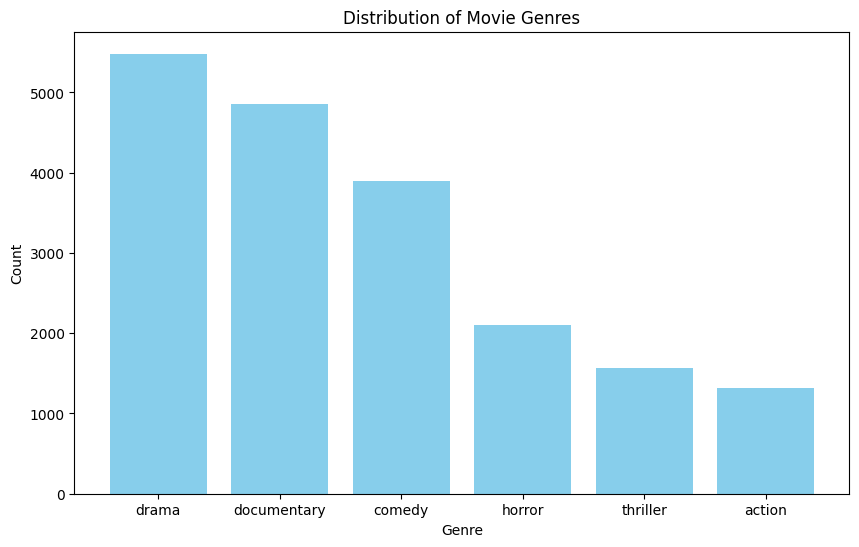

In [2]:
train_data = pd.read_csv("train.csv")

genre_counts = train_data["genre"].value_counts()


plt.figure(figsize=(10, 6))
plt.bar(genre_counts.index, genre_counts.values, color="skyblue")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.title("Distribution of Movie Genres")
plt.xticks(genre_counts.index, genre_counts.index.tolist())
plt.show()

Drama and documentary genres are the most common, with 5483 and 4861
occurrences, respectively. Comedy is the third most common genre with 3896
occurrences.Horror, thriller, and action genres have fewer occurrences compared
to drama, documentary, and comedy, with 2104, 1568, and 1312 occurrences,
respectively. The distribution of the dataset is imbalanced, with drama and
documentary genres dominating the dataset, while horror, thriller, and action
genres are underrepresented. This class imbalance can potentially affect the
performance of machine learning models, particularly for genres with fewer
occurrences, as the model may struggle to generalize well to these classes.

In [3]:
train_data = pd.read_csv("train.csv")
validation_data = pd.read_csv("validate.csv")
test_data = pd.read_csv("test.csv")

In [4]:
X_train = train_data.drop(columns=["genre"])
y_train = train_data["genre"]
X_val = validation_data.drop(columns=["genre"])
y_val = validation_data["genre"]
X_test = test_data.drop(columns=["ID"]).values

In [5]:
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_val_normalized = scaler.transform(X_val)

In [6]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train_encoded), y=y_train_encoded
)

In [7]:
def build_model(hidden_layers, hidden_nodes, learning_rate):
    model = tf.keras.Sequential()
    model.add(
        tf.keras.layers.Dense(
            hidden_nodes, activation="relu", input_shape=(X_train.shape[1],)
        )
    )
    for _ in range(hidden_layers - 1):
        model.add(tf.keras.layers.Dense(hidden_nodes, activation="relu"))
    model.add(tf.keras.layers.Dense(len(label_encoder.classes_), activation="softmax"))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [8]:
def plot_training_history(history, title):
    plt.plot(history.history["loss"], label="Train")
    plt.plot(history.history["val_loss"], label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.title(title)
    plt.legend()
    plt.show()

In [9]:
def evaluate_model(model, X_train, y_train, X_val, y_val):
    y_train_pred_data = model.predict(X_train)
    y_train_pred = np.argmax(y_train_pred_data, axis=1)
    y_val_pred_data = model.predict(X_val)
    y_val_pred = np.argmax(y_val_pred_data, axis=1)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    val_accuracy = accuracy_score(y_val, y_val_pred)

    conf_matrix = confusion_matrix(y_val, y_val_pred)
    class_wise_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

    print("Accuracy Scores:")
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Validation Accuracy: {val_accuracy}")

    print("\nClassification Report:")
    print(classification_report(y_val, y_val_pred, target_names=label_encoder.classes_))

    print("\nClass-wise Accuracy:")
    for genre, acc in zip(label_encoder.classes_, class_wise_accuracy):
        print(f"{genre}: {acc}")

In [10]:
model_structures = [
    {"hidden_layers": 1, "hidden_nodes": 64},
    {"hidden_layers": 2, "hidden_nodes": 32},
    {"hidden_layers": 2, "hidden_nodes": 64},
]

for idx, structure in enumerate(model_structures, start=1):
    hidden_layers = structure["hidden_layers"]
    hidden_nodes = structure["hidden_nodes"]
    learning_rate = 0.001
    epochs = 100

    print(
        f"\nModel {idx}: Hidden Layers: {hidden_layers}, Hidden Nodes: {hidden_nodes}"
    )
    model = build_model(hidden_layers, hidden_nodes, learning_rate)
    history = model.fit(

        X_train,
        y_train_encoded,
        epochs=epochs,
        validation_data=(X_val, y_val_encoded),
        verbose=0,
    )

    plot_training_history(history, f"Model {idx}: Training vs Validation Error")

    evaluate_model(model, X_train, y_train_encoded, X_val, y_val_encoded)

Model 1 with 1 hidden layer and 64 hidden nodes achieves a training accuracy of 0.690 and a validation accuracy of 0.635.
Model 2 with 2 hidden layers and 32 hidden nodes achieves a training accuracy of 0.685 and a validation accuracy of 0.647.
Model 3 with 2 hidden layers and 64 hidden nodes achieves a training accuracy of 0.712 and a validation accuracy of 0.653.
From these performances, we can observe the following:

Model 3, which has the highest number of hidden nodes (64) and the best performance, achieves the highest validation accuracy. This suggests that increasing the complexity of the model by adding more hidden nodes can improve performance, up to a certain point.

Model 2, with two hidden layers, performs slightly better than Model 1 with only one hidden layer. This indicates that adding depth to the network can also contribute to better performance, although the improvement is not as significant as increasing the number of nodes.

 While Model 3 achieves the highest training accuracy, its validation accuracy is not significantly higher compared to Model 2, suggesting that Model 3 might be overfitting to the training data. Therefore, it's essential to strike a balance between model complexity and generalization performance to avoid overfitting.

In summary, Model 3 with 2 hidden layers and 64 hidden nodes seems to strike a good balance between model complexity and performance, achieving the highest validation accuracy among the three models. However, further tuning and experimentation may be necessary to optimize the model's performance further.


Model 1: Hidden Layers: 4, Hidden Nodes: 128
Epoch 1/100


/Users/chinemerem/Documents/GitHub/ECE457B/env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


601/601 ━━━━━━━━━━━━━━━━━━━━ 1s 987us/step - accuracy: 0.2887 - loss: 1.7103 - val_accuracy: 0.4240 - val_loss: 1.6155
Epoch 2/100
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - accuracy: 0.3733 - loss: 1.6098 - val_accuracy: 0.3890 - val_loss: 1.5551
Epoch 3/100
601/601 ━━━━━━━━━━━━━━━━━━━━ 1s 913us/step - accuracy: 0.4128 - loss: 1.5259 - val_accuracy: 0.4473 - val_loss: 1.4440
Epoch 4/100
601/601 ━━━━━━━━━━━━━━━━━━━━ 1s 957us/step - accuracy: 0.4344 - loss: 1.4293 - val_accuracy: 0.4610 - val_loss: 1.3759
Epoch 5/100
601/601 ━━━━━━━━━━━━━━━━━━━━ 1s 925us/step - accuracy: 0.4640 - loss: 1.3673 - val_accuracy: 0.4637 - val_loss: 1.3305
Epoch 6/100
601/601 ━━━━━━━━━━━━━━━━━━━━ 1s 869us/step - accuracy: 0.4855 - loss: 1.3238 - val_accuracy: 0.5086 - val_loss: 1.3077
Epoch 7/100
601/601 ━━━━━━━━━━━━━━━━━━━━ 1s 924us/step - accuracy: 0.5004 - loss: 1.2948 - val_accuracy: 0.5037 - val_loss: 1.2684
Epoch 8/100
601/601 ━━━━━━━━━━━━━━━━━━━━ 1s 907us/step - accuracy: 0.5144 - loss: 1.2735 - val_

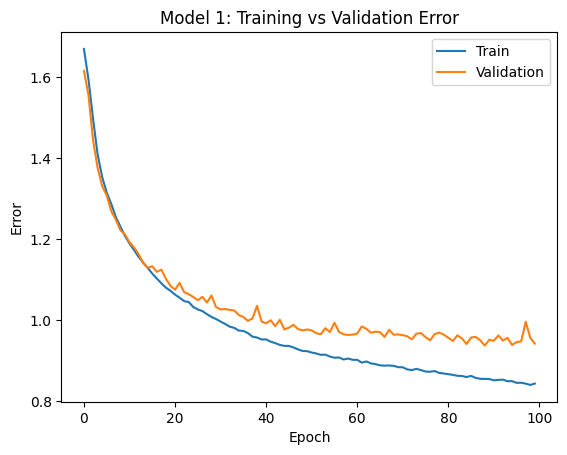

601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
Accuracy Scores:
Training Accuracy: 0.681960049937578
Validation Accuracy: 0.652095410054167

Classification Report:
              precision    recall  f1-score   support

      action       0.54      0.52      0.53       657
      comedy       0.66      0.57      0.61      2241
 documentary       0.73      0.86      0.79      2716
       drama       0.61      0.65      0.63      3012
      horror       0.65      0.75      0.70      1102
    thriller       0.44      0.16      0.23       795

    accuracy                           0.65     10523
   macro avg       0.61      0.58      0.58     10523
weighted avg       0.64      0.65      0.64     10523


Class-wise Accuracy:
action: 0.5159817351598174
comedy: 0.5676037483266398
documentary: 0.864138438880707
drama: 0.649402390438247
horror: 0.7459165154264973
thriller: 0.15849056603773584


In [11]:
best_val_accuracy = 0.0
best_model = None

model_structures = [
    {"hidden_layers": 4, "hidden_nodes": 128, "learning_rate": 0.00003},
]

for idx, structure in enumerate(model_structures, start=1):
    hidden_layers = structure["hidden_layers"]
    hidden_nodes = structure["hidden_nodes"]
    learning_rate = structure["learning_rate"]
    epochs = 100

    print(
        f"\nModel {idx}: Hidden Layers: {hidden_layers}, Hidden Nodes: {hidden_nodes}"
    )
    model = build_model(hidden_layers, hidden_nodes, learning_rate)
    history = model.fit(
        X_train,
        y_train_encoded,
        epochs=epochs,
        validation_data=(X_val, y_val_encoded),
        verbose=1,
    )

    predictions = model.predict(X_test)

    submission_df = pd.DataFrame(
        {"ID": test_data["ID"], "label": np.argmax(predictions, axis=1) + 1}
    )

    submission_df.to_csv("submission.csv", index=False)

    plot_training_history(history, f"Model {idx}: Training vs Validation Error")

    evaluate_model(model, X_train, y_train_encoded, X_val, y_val_encoded)

/Users/chinemerem/Documents/GitHub/ECE457B/env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


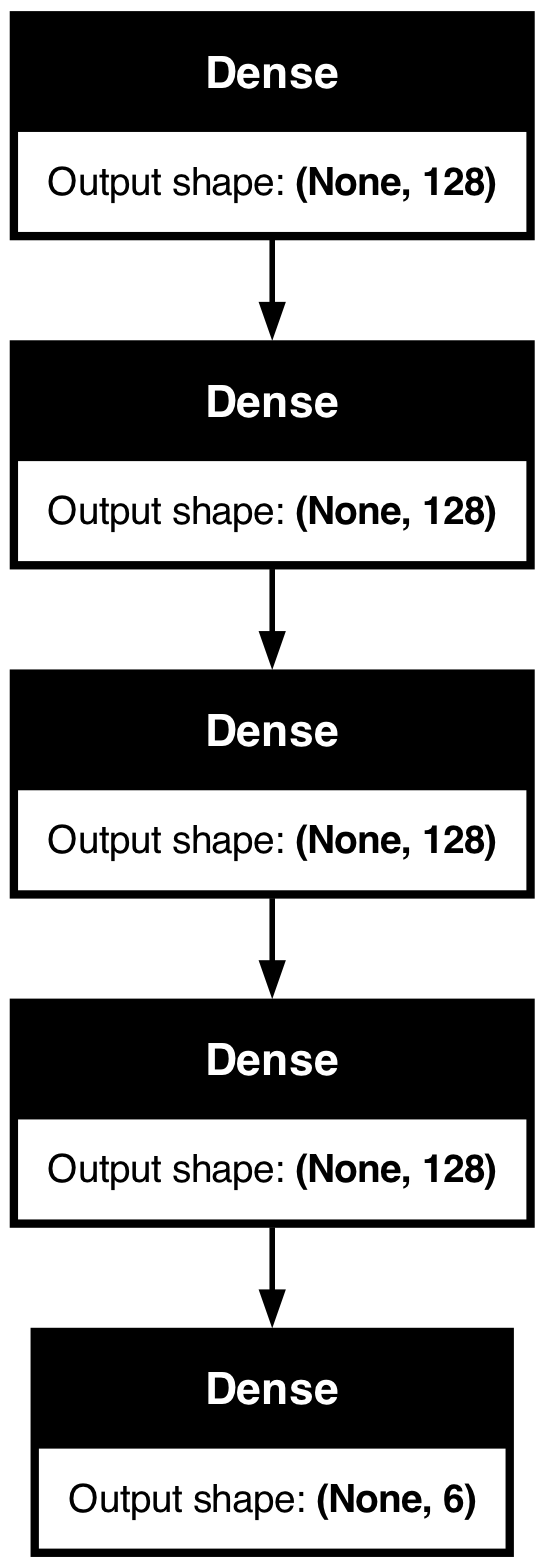

In [15]:
def build_model(hidden_layers, hidden_nodes):
    model = tf.keras.Sequential()
    # Input layer
    model.add(
        tf.keras.layers.Dense(hidden_nodes, activation="relu", input_shape=(input_shape,))
    )
    # Hidden layers
    for _ in range(hidden_layers - 1):
        model.add(tf.keras.layers.Dense(hidden_nodes, activation="relu"))
    # Output layer
    model.add(tf.keras.layers.Dense(num_classes, activation="softmax"))
    return model


# Parameters
hidden_layers = 4
hidden_nodes = 128
input_shape = 100  # Define the input shape according to your data
num_classes = 6  # Assuming you have 6 output classes

# Build the model
model = build_model(hidden_layers, hidden_nodes)

# Plot the model architecture
plot_model(model, show_shapes=True)

I chose this design because of question 4.1. In that question I noticed that
by incresing layers and hidden nodes, model performance slowly increased. I
thereby added more layers and hidden nodes, while reducing the learning rate to
avoid overfitting.